[View in Colaboratory](https://colab.research.google.com/github/123miles/AdaptiveSystems_project/blob/master/CIFAR_GAN_2.ipynb)

In [2]:
!pip install torchvision
!pip install tensorboardX
!pip install pillow==4.1.1

In [0]:
import os
import numpy as np
import errno
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import numpy as np



'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        var_class = torch.autograd.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)

        if format=='NHWC':
            images = images.transpose(1,3)


        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):

        var_class = torch.autograd.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()[0]
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()[0]
        if type(d_pred_real)==var_class:
            d_pred_real = d_pred_real.data
        if type(d_pred_fake)==var_class:
            d_pred_fake = d_pred_fake.data


        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise


In [4]:
def CIFAR_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
          ])
    out_dir = './dataset'
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

  
# Load data
Cdata = CIFAR_data()

# Create loader with data, so that we can iterate over it
Cdata_loader = torch.utils.data.DataLoader(Cdata, batch_size=100, shuffle=True)
# Num batches
num_batches = len(Cdata_loader)

Files already downloaded and verified


In [0]:
MNISTN = 784
CIFARN = 3072

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self, N):
        super(DiscriminatorNet, self).__init__()
        self.n_features = N
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(self.n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet(CIFARN)

In [0]:
def Cimages_to_vectors(images):
    return images.view(images.size(0), 3072)

def Cvectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 32, 32)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, N):
        super(GeneratorNet, self).__init__()
        n_features = 100
        self.n_out = N
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet(CIFARN)

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
        return n.cuda()
    return n

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error

In [0]:
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
  

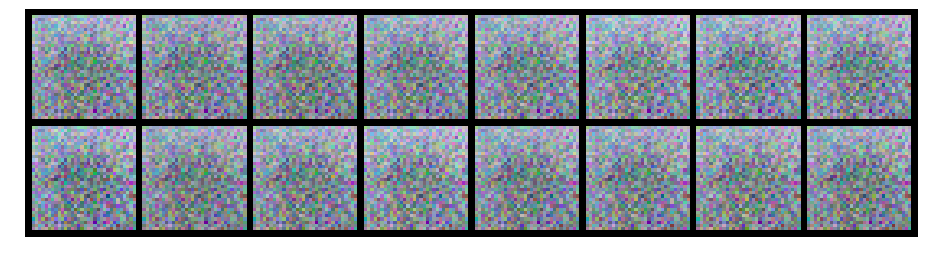

Epoch: [0/500], Batch Num: [499/500]
Discriminator Loss: 1.4437, Generator Loss: 1.0722
D(x): 0.8357, D(G(z)): 0.5982


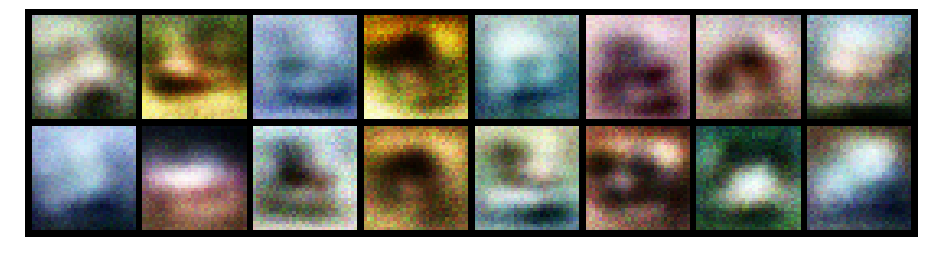

Epoch: [20/500], Batch Num: [499/500]
Discriminator Loss: 1.0940, Generator Loss: 1.2740
D(x): 0.6268, D(G(z)): 0.3597


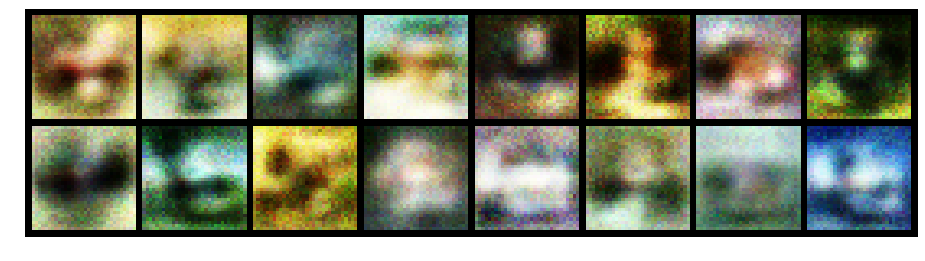

Epoch: [40/500], Batch Num: [499/500]
Discriminator Loss: 1.0959, Generator Loss: 1.1944
D(x): 0.6069, D(G(z)): 0.3416


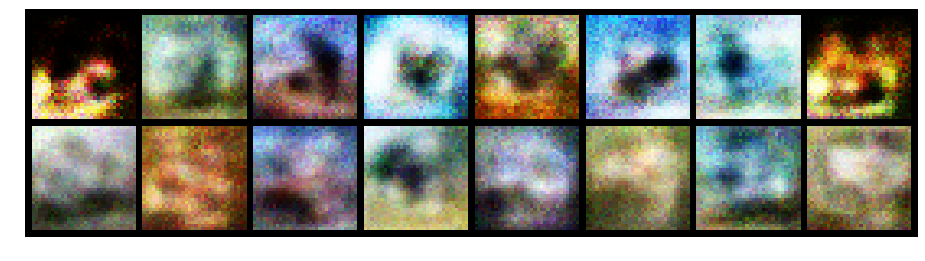

Epoch: [60/500], Batch Num: [499/500]
Discriminator Loss: 1.1984, Generator Loss: 0.9284
D(x): 0.5637, D(G(z)): 0.4146


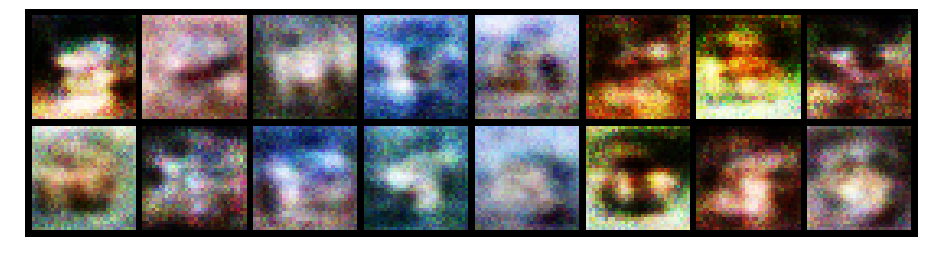

Epoch: [80/500], Batch Num: [499/500]
Discriminator Loss: 1.5496, Generator Loss: 1.0643
D(x): 0.5313, D(G(z)): 0.4249


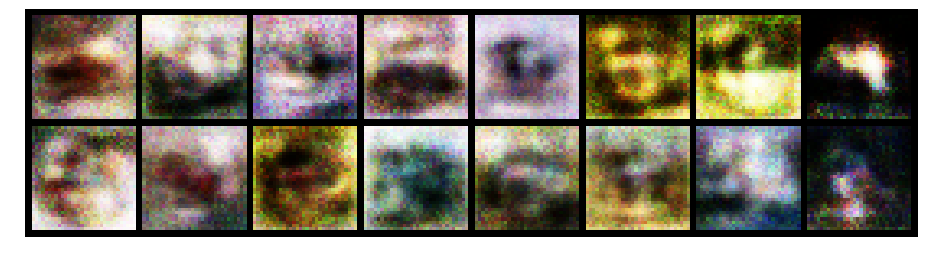

Epoch: [100/500], Batch Num: [499/500]
Discriminator Loss: 1.1523, Generator Loss: 1.2363
D(x): 0.5817, D(G(z)): 0.3663


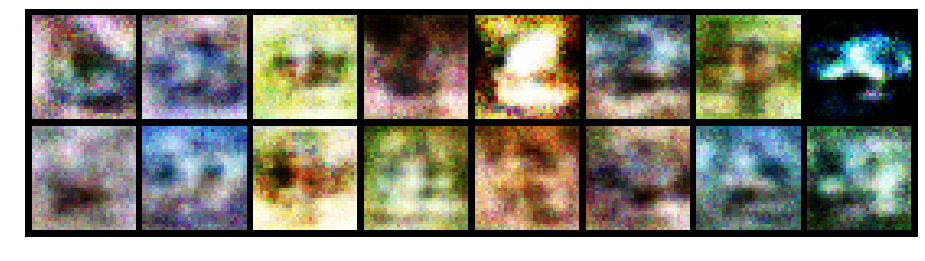

Epoch: [120/500], Batch Num: [499/500]
Discriminator Loss: 1.2842, Generator Loss: 0.9295
D(x): 0.5607, D(G(z)): 0.4519


In [0]:
# Create logger instance
#logger = Logger(model_name='VGAN', data_name='MNIST')
logger = Logger(model_name='VGAN', data_name='CIFAR')

# Total number of epochs to train
num_epochs = 500

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(Cdata_loader):
        N = real_batch.size(0)

        # 1. Train Discriminator
        real_data = Variable(Cimages_to_vectors(real_batch))
        if torch.cuda.is_available():
            real_data = real_data.cuda()

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()

        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator

        # Generate fake data
        fake_data = generator(noise(N))

        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

    # Display Progress every few batches
        
    if epoch % 20 == 0: 
        test_images = Cvectors_to_images(generator(test_noise))
        test_images = (test_images.data).to(torch.device('cpu'))

        logger.log_images(
          test_images.numpy(), num_test_samples, 
          epoch, n_batch, num_batches
        );

        # Display status Logs
        logger.display_status(
            epoch, num_epochs, n_batch, num_batches,
            d_error, g_error, d_pred_real, d_pred_fake
         )    